# Single-Order Spectrum

This will show how to fit a single-order spectrum using our [previous setup](setup.ipynb) on [WASP14](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=wasp+14&submit=SIMBAD+search) TRES data.

In [1]:
%load_ext autoreload
%autoreload 2

## Preprocessing

So the first thing we need to do is pre-process our data. Here we loud the original dataset.

In [2]:
import h5py

with h5py.File('WASP14-2009-12-24.hdf5') as base:
    wls = base['wls'][:]
    fls = base['fls'][:]
    sigmas = base['sigmas'][:]

In [3]:
wls.shape

(51, 2298)

Now I'm going to select a single order to fit, and create a new `DataSpectrum`

In [4]:
from Starfish.spectrum import DataSpectrum

order = 22
wave = wls[order]
flux = fls[order]
sigma = sigmas[order]
# Remove errant absorption. See full dataset for more info
mask = flux < 1e-13 

data = DataSpectrum(wave, flux, sigma, mask, name=f'WASP 14: Order {order}')
data.save('WASP14_o22.hdf5')

And lets take a look at our data

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['text.usetex'] = True

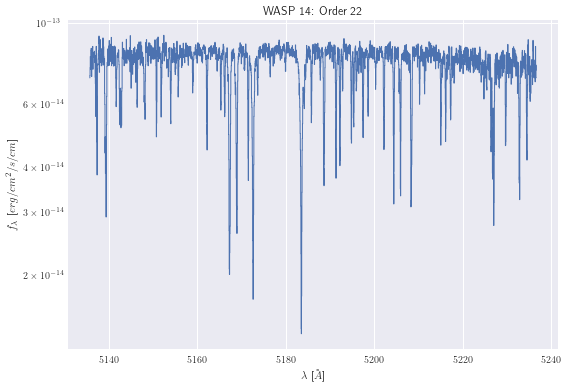

In [7]:
plt.step(data.waves, data.fluxes, lw=1)
plt.yscale('log')
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.ylabel(r'$f_\lambda$ [$erg/cm^2/s/cm$]')
plt.title(f'WASP 14: Order {order}')
plt.tight_layout()

## Setting up the model

Now we can set up our initial model. We need, at minimum, an emulator, our data, and a set of the library grid parameters. Every extra keyword argument we add is added to our list of parameters. For more information on what parameters are available and what effect they have, see the [SpectrumModel documentation](). 

Some of these parameters are based on guesses or pre-existing knowledge. In particular, it's important to tune `log_scale` to a reasonable value, so take some iterations of plotting against the data to get a good starting point.

In [92]:
from Starfish.emulator import Emulator
from Starfish.models import SpectrumModel

emu = Emulator.load('F_TRES_emu.hdf5')
model = SpectrumModel(
    emu, 
    data, 
    grid_params=[6300, 5.0, -0.5],
    log_scale=-13,
    vz = 0,
    vsini = 5,
    Av = 0.0,
    glob=dict(log_amp=-14, log_ls=2)
)
model

SpectrumModel
-------------
Data: WASP 14: Order 22
Parameters:
	T: 6300
	logg: 5.0
	Z: -0.5
	log_scale: -13
	vz: 0
	vsini: 5
	Av: 0.0
Global Parameters:
	log_amp: -14
	log_ls: 2

Log Likelihood: 19816.89

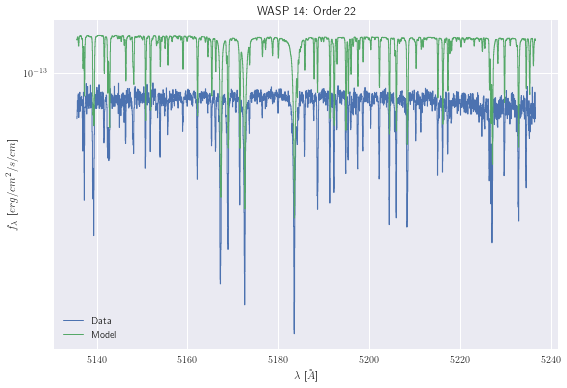

In [93]:
model_flux, model_cov = model()
plt.step(data.waves, data.fluxes, lw=1, label='Data')
plt.step(data.waves, model_flux, lw=1, label='Model')
plt.legend()
plt.yscale('log')
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.ylabel(r'$f_\lambda$ [$erg/cm^2/s/cm$]')
plt.title(f'WASP 14: Order {order}')
plt.tight_layout()

## Numerical Optimization

Now lets do a *maximum a posteriori* (MAP) point estimate for our data. Note that we freeze `logg` here because the PHOENIX models' response to `logg` compared to our data are relatively flat, so we fix the value using the [freeze]() mechanics.

In [94]:
model.freeze(['logg', 'global:log_amp', 'global:log_ls'])
# These are the fittable parameters
model.labels

['T', 'Z', 'log_scale', 'vz', 'vsini', 'Av']

In [95]:
from scipy.optimize import minimize
import scipy.stats as st
log_scale_prior = st.uniform(-14, 2)

def nll(P):
    model.set_param_vector(P)
    ll = model.log_likelihood()
    ll += log_scale_prior.logpdf(model['log_scale'])
    return -ll

P0 = model.get_param_vector()

In [96]:
%time soln = minimize(nll, P0, method='Nelder-Mead')

CPU times: user 3min 56s, sys: 1min 3s, total: 5min
Wall time: 2min 21s


In [97]:
model.set_param_vector(soln.x)
model

SpectrumModel
-------------
Data: WASP 14: Order 22
Parameters:
	T: 6300.0
	logg: 5.0
	Z: -0.5
	log_scale: -13.0
	vz: 0.0
	vsini: 5.0
	Av: 1.220703125e-07
Global Parameters:
	log_amp: -14
	log_ls: 2

Log Likelihood: 19816.89

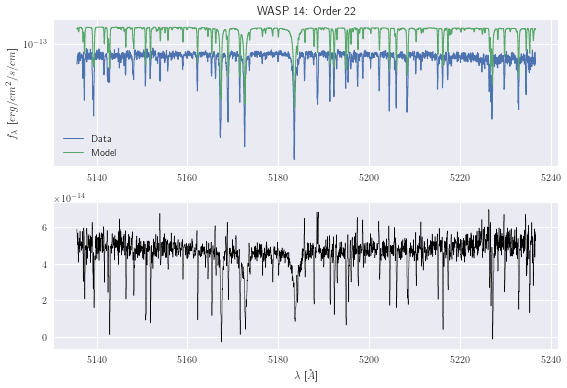

In [98]:
model_flux, model_cov = model()
var = model_cov.diagonal() ** 2


plt.subplot(211)
plt.step(data.waves, data.fluxes, lw=1, label='Data')
plt.step(data.waves, model_flux, lw=1, label='Model')
plt.legend()
plt.yscale('log')
plt.ylabel(r'$f_\lambda$ [$erg/cm^2/s/cm$]')
plt.title(f'WASP 14: Order {order}')

plt.subplot(212)
plt.step(data.waves, model_flux - data.fluxes, c='k', lw=.5)
# plt.fill_between(data.waves, 2*var, -2*var, color='C2', alpha=0.3)
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.tight_layout()